# Tutorial: data integration for PBMC data (10x Genomics Visium)

In this tutorial, we demonstrate how to apply FGOT to integrate paired PBMC data. The dataset is publicly assessible (https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_granulocyte_sorted_10k?). After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/1CdQkf9L4xIr2Xw4oazHcYOIgC47z6Ou9). 

## load package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
import sys
sys.path.insert(1, '/home/nas2/biod/yangchenghui/FGOT-master')
import FGOT
from FGOT import preprocess as pre
from FGOT import fgot_sparse_tensor, fgot_tol, align
from FGOT import metrics as mt

## load data

In [3]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/PBMC_data/"
RNA_data = pd.read_csv(data_path+'feature_selected_RNA_normalized.txt', sep='\t', index_col=0)
ATAC_data = pd.read_csv(data_path+'feature_250kb_ATAC_normalized.txt', sep='\t', index_col=0)

RNA_cluster = pd.read_csv(data_path+'label.txt', sep='\t').rename(columns={'Unnamed: 0': 'cell', 'metas': 'cluster'})
ATAC_cluster = RNA_cluster.copy()

In [4]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (3197, 7835)  X2 =  (3197, 215)
Dimensions of basic_labels are:  basic_labels1 =  (3197,)  basic_labels2 =  (3197,)


## build a priori feature graph

In [5]:
promoters = pd.read_csv(data_path+'hg38.promoter.regions.txt', sep = '\t')
promoters.head()

,chr,starts,ends,genes
1,chr1,12623,12624.0,DDX11L1
2,chr1,30120,30121.0,WASH7P
3,chr1,18186,18187.0,MIR6859.1
4,chr1,18186,18187.0,MIR6859.2
5,chr1,18186,18187.0,MIR6859.3


In [6]:
feature_matrix = pre.prior_feature_graph(promoters, peak_names, gene_names)
feature_matrix

72337it [00:00, 75167.18it/s] 
41399it [00:01, 22550.94it/s]
100%|██████████| 215/215 [00:02<00:00, 86.75it/s] 


The number of gene nodes, peak nodes, and edges in the prior feature graph is: 215 7835 9115


100%|██████████| 9115/9115 [00:00<00:00, 669487.45it/s]


,NIPAL3,RCAN3AS,RCAN3,HYI,CD52,GAS5,LINC01135,COL24A1,RPL5,DIPK1A,...,PRKCH,PTGDR,GZMH,TNFAIP2,CEP128,TCF4,BCL2,LINC01478,SETBP1,TTC39C
chr17-48456637-48457880,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr16-3011951-3014525,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-54434338-54435688,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr19-35484675-35485088,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr1-160284015-160285824,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr19-18414123-18442655,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr12-31705380-31706105,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
chr18-55778545-55781183,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,1.0,inf,inf,inf,inf
chr10-70363713-70365125,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


## compute cost across modalities

We use wnn to calculate cost for paired data.

In [7]:
wnn = pd.read_csv(data_path+'PBMC_wnn.txt', sep='\t', index_col=0)
wnn

,Agg_1,Agg_2,Agg_3,Agg_4,Agg_5,Agg_6,Agg_7,Agg_8,Agg_9,Agg_10,...,Agg_3192,Agg_3193,Agg_3194,Agg_3195,Agg_3196,Agg_3197,Agg_3198,Agg_3199,Agg_3200,Agg_3201
Agg_1,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_2,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_3,0.0,0.0,1.000000,0.176471,0.0,0.0,0.000000,0.000000,0.081081,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_4,0.0,0.0,0.176471,1.000000,0.0,0.0,0.000000,0.000000,0.379310,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Agg_5,0.0,0.0,0.000000,0.000000,1.0,0.0,0.111111,0.176471,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_3197,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.538462,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.212121,0.000000
Agg_3198,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.176471,0.081081,0.212121,0.000000,1.000000,0.379310,0.000000,0.176471
Agg_3199,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.250000,0.000000,0.428571,0.142857,0.538462,0.000000,0.379310,1.000000,0.000000,0.481481
Agg_3200,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.176471,0.142857,0.000000,0.250000,0.000000,0.212121,0.000000,0.000000,1.000000,0.000000


In [8]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

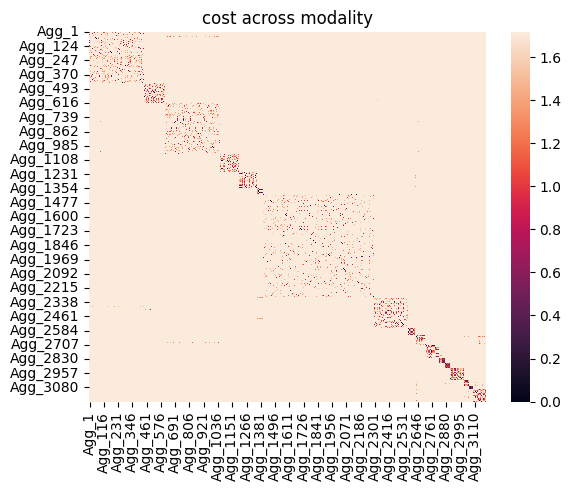

In [9]:
sns.heatmap(cost)
pl.title('cost across modality')

## scale

In [10]:
scaler = StandardScaler()
X1, X2 = scaler.fit_transform(X1), scaler.fit_transform(X2)
X1 = pd.DataFrame(X1,index= cell_names1,columns=peak_names)
X2 = pd.DataFrame(X2,index= cell_names2,columns=gene_names)

## solve the feature-guided optimal transport problem

In [11]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:3', eps_p = 1e-1)

minibatch = 1 and device =  cuda:3
the total number of computing batch is  6


100%|██████████| 6/6 [1:10:27<00:00, 704.52s/it]


## make multi-omics alignment from the transport tensor

In [12]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 9115/9115 [10:43<00:00, 14.17it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

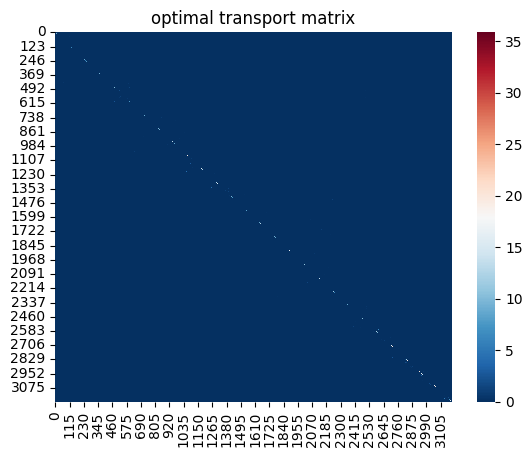

In [13]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [14]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterp

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

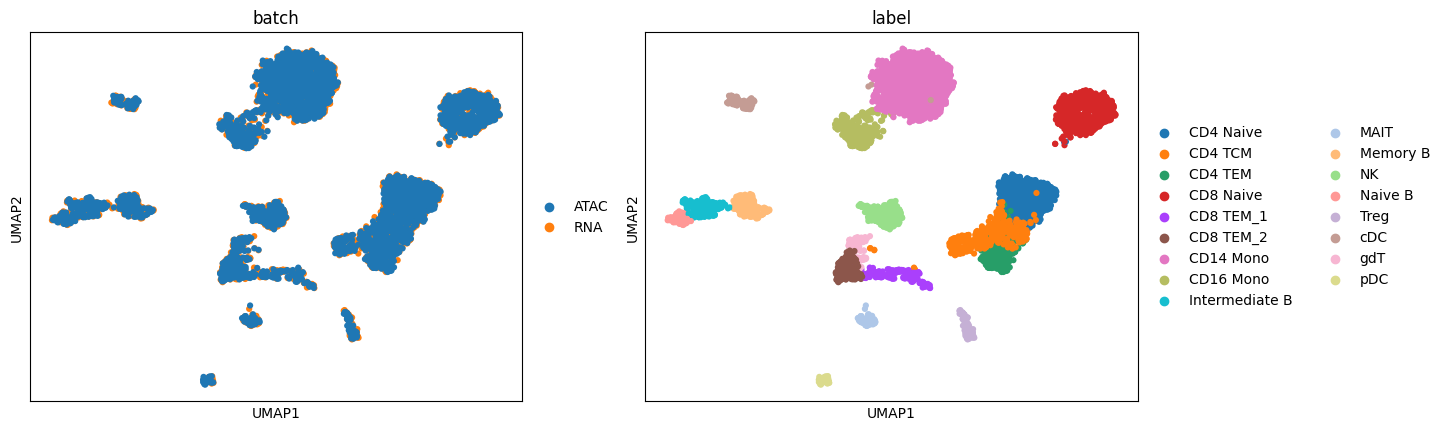

In [15]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)

## infer the cell type specific regulatory intensity from the transport tensor

In [16]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

  0%|          | 0/215 [00:00<?, ?it/s]

100%|██████████| 215/215 [41:18<00:00, 11.53s/it] 


,CD8 TEM_1,Memory B,Naive B,CD16 Mono,gdT,Treg,CD4 TCM,cDC,MAIT,CD4 Naive,CD14 Mono,Intermediate B,CD8 TEM_2,CD8 Naive,NK,CD4 TEM,pDC
SKAP1-chr17-48456637-48457880,0.000026,0.000016,0.000011,1.029707e-06,0.000033,0.000152,9.755575e-06,5.713485e-07,0.000108,5.154197e-06,5.918555e-08,5.349195e-06,2.591975e-05,5.359464e-06,1.176202e-05,2.356547e-05,0.000021
SKAP1-chr17-48546588-48549046,0.000005,0.000006,0.000004,9.899334e-07,0.000009,0.000081,6.305265e-06,1.509475e-06,0.000019,7.077382e-06,2.122333e-07,9.215374e-07,1.564485e-05,6.210356e-06,1.337705e-05,1.266539e-05,0.000020
SKAP1-chr17-48294194-48295986,0.000023,0.000013,0.000014,1.415063e-06,0.000049,0.000014,1.468921e-05,1.367662e-06,0.000192,2.412635e-06,2.074437e-07,4.319733e-06,1.883837e-05,2.130711e-06,1.656856e-05,8.628647e-06,0.000020
SKAP1-chr17-48444176-48445511,0.000023,0.000013,0.000005,5.975401e-07,0.000086,0.000006,7.523250e-06,8.579099e-11,0.000046,5.849760e-06,1.326725e-08,6.173935e-06,3.352926e-05,1.040908e-05,1.567375e-05,1.256924e-05,0.000001
SKAP1-chr17-48526772-48527749,0.000027,0.000010,0.000003,7.705217e-07,0.000022,0.000084,5.554314e-06,3.174198e-08,0.000018,5.415351e-06,1.213093e-07,3.934099e-06,1.133189e-05,5.835262e-06,1.421761e-05,1.384550e-05,0.000012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PATJ-chr1-61641679-61642101,0.000045,0.000096,0.000151,1.571413e-05,0.000000,0.000000,1.002362e-05,3.410916e-05,0.000000,8.543686e-06,1.197715e-06,2.774878e-05,1.054017e-05,1.124170e-05,2.013114e-05,9.069146e-05,0.000136
NEGR1-chr1-72366388-72366903,0.000000,0.000000,0.000120,6.522396e-05,0.000000,0.000000,5.846758e-08,3.747267e-03,0.000000,1.721512e-07,5.333845e-05,5.017254e-05,0.000000e+00,1.671522e-07,7.198439e-05,1.047143e-06,0.003596
NEGR1-chr1-72281087-72285474,0.000012,0.000071,0.000014,1.424268e-04,0.000000,0.000000,5.741996e-07,3.224813e-03,0.000034,1.924014e-06,4.557978e-05,3.288449e-05,9.416780e-07,7.522510e-06,7.116970e-05,7.348870e-06,0.006707
NEGR1-chr1-72288865-72289444,0.000014,0.000108,0.000002,6.479039e-05,0.000000,0.000000,4.247734e-09,1.786734e-03,0.000000,0.000000e+00,5.617424e-05,0.000000e+00,0.000000e+00,2.792785e-08,1.921634e-07,2.635097e-07,0.001114


## solve the feature-guided optimal transport problem by an anchor-based minibatch strategy

In [17]:
P_anchor = FGOT.fgot.transfer_anchor(X1, X2, feature_matrix, cost, \
    ATAC_cluster, RNA_cluster, pair=True, wnn=wnn,\
    minibatch=1, batchsize = 380, device='cuda:3', eps_p=1e-1)
P_anchor

Identify (797, 797) anchor cells!
minibatch = 1 and device =  cuda:3
the total number of computing batch is  2


100%|██████████| 9115/9115 [00:06<00:00, 1334.73it/s]


,Agg_1,Agg_2050,Agg_4,Agg_2053,Agg_2055,Agg_2056,Agg_2057,Agg_2058,Agg_14,Agg_2063,...,Agg_2022,Agg_2027,Agg_2031,Agg_2032,Agg_2036,Agg_2038,Agg_2039,Agg_2040,Agg_2043,Agg_2047
Agg_1,17.822646,0.000879,0.000000,0.000535,0.000000,0.000143,0.000000,0.000000,0.001589,0.000000,...,0.000000,0.000000,0.001446,0.000272,0.000000,0.000613,0.000000,0.000000,0.000000,0.000588
Agg_2050,0.001094,19.527025,0.000000,0.001085,0.000000,0.000511,0.000000,0.000000,0.004364,0.000000,...,0.000000,0.000000,0.003287,0.000832,0.000000,0.001175,0.000000,0.000000,0.000000,0.000981
Agg_4,0.000000,0.000000,21.031905,0.000000,0.003852,0.000000,0.000414,0.000475,0.000000,0.000576,...,0.000488,0.000637,0.000000,0.000000,0.000368,0.000000,0.000731,0.000454,0.000648,0.000000
Agg_2053,0.001022,0.000896,0.000000,16.845061,0.000000,0.000497,0.000000,0.000000,0.003605,0.000000,...,0.000000,0.000000,0.002959,0.000805,0.000000,0.000863,0.000000,0.000000,0.000000,0.131963
Agg_2055,0.000000,0.000000,0.001385,0.000000,29.856367,0.000000,0.000592,0.000697,0.000000,0.000779,...,0.000694,0.024096,0.000000,0.000000,0.000400,0.000000,0.000624,0.000790,0.017695,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Agg_2038,0.001254,0.001340,0.000000,0.001071,0.000000,0.000478,0.000000,0.000000,0.003204,0.000000,...,0.000000,0.000000,0.003148,0.000808,0.000000,21.006347,0.000000,0.000000,0.000000,0.001157
Agg_2039,0.000000,0.000000,0.001900,0.000000,0.003624,0.000000,0.001149,0.001217,0.000000,0.001202,...,0.001183,0.002082,0.000000,0.000000,0.000690,0.000000,19.911000,0.001307,0.001485,0.000000
Agg_2040,0.000000,0.000000,0.002026,0.000000,0.003808,0.000000,0.000997,0.001151,0.000000,0.001344,...,0.261702,0.004346,0.000000,0.000000,0.000658,0.000000,0.000981,20.869039,0.001528,0.000000
Agg_2043,0.000000,0.000000,0.002168,0.000000,0.128342,0.000000,0.001359,0.001367,0.000000,0.001444,...,0.001356,0.018936,0.000000,0.000000,0.000818,0.000000,0.001138,0.001635,34.084758,0.000000


In [18]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost, ATAC_cluster, RNA_cluster,\
    minibatch=1, batchsize=500, pair = True, device='cuda:3', eps_p = 1e-1,\
    fastMinibatch=False, P_anchor=P_anchor)

minibatch = 1 and device =  cuda:3
the total number of computing batch is  6


100%|██████████| 6/6 [56:11<00:00, 561.94s/it]


## make multi-omics alignment from the transport tensor

In [19]:
P = fgot_tol(P_tensor)
P.shape

  0%|          | 0/9115 [00:00<?, ?it/s]

100%|██████████| 9115/9115 [03:22<00:00, 45.09it/s]


(3197, 3197)

Text(0.5, 1.0, 'optimal transport matrix')

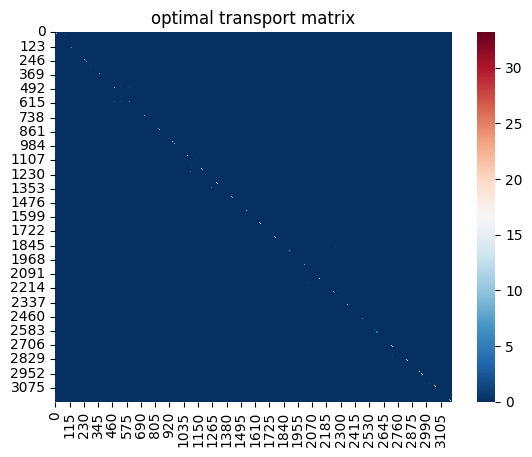

In [20]:
sns.heatmap(P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [21]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yangchenghui/anaconda3/envs/py310/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Cat

[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

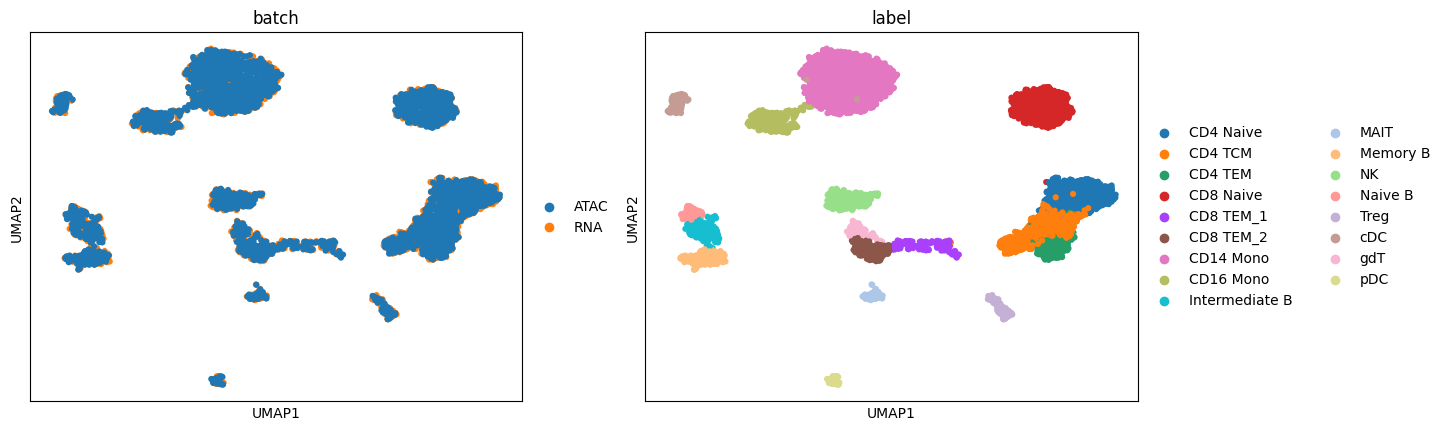

In [22]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80, show=False)